# Book Data Exploration & Processing
This notebook performs environment setup, data loading, EDA, visualizations, basic cleaning, saves processed datasets and figures, and includes a simple modeling example. It uses `books_data.json` from `Mock_student_packet_v4/`.

## 1) Environment Setup
- Commands to create a venv and install dependencies.

```bash
python -m venv .venv
# Windows (PowerShell)
.venv\Scripts\Activate.ps1
pip install -r requirements.txt
```

This notebook will attempt to install missing Python packages automatically if needed.

In [ ]:
# Install common packages if missing and write requirements.txt
import importlib, subprocess, sys
reqs = ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "pyarrow", "joblib"]
installed = []
for pkg in reqs:
    try:
        importlib.import_module(pkg)
        installed.append(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        installed.append(pkg)
# Write requirements
subprocess.check_call([sys.executable, "-m", "pip", "freeze", "--local"], stdout=open('requirements.txt','w'))
print('Installed/verified:', installed)


## 2) Configure Jupyter Kernel
To register the environment as a kernel (run in terminal after activating venv):

```bash
python -m ipykernel install --user --name=mock_env --display-name "Python (mock_env)"
```

Then select the kernel in VS Code's kernel picker.

In [ ]:
# Quick sanity checks and magic
%matplotlib inline
print('Hello, world — notebook environment is ready')

In [1]:
# Imports and helper functions
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import joblib

ROOT = Path('.') / 'Mock_student_packet_v4'
FIG_DIR = Path('figures')
PROC_DIR = Path('data/processed')
FIG_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR.mkdir(parents=True, exist_ok=True)

sns.set(style='whitegrid')

def save_fig(fig, name, dpi=150):
    path = FIG_DIR / name
    fig.tight_layout()
    fig.savefig(path, dpi=dpi)
    print('Saved figure:', path)


In [ ]:
# Data Loading
books_path = ROOT / 'books_data.json'

books = pd.read_json(books_path)

print('books:', books.shape)

# Save quick I/O checks
books.describe(include='all').to_csv(PROC_DIR / 'books_describe.csv')


wine: (1599, 12)
books: (1000, 8)


In [3]:
# Basic EDA - books
print('Books head:')
print(books.head().to_string(index=False))
print('\nDtypes:\n', books.dtypes)
print('\nMissing values:\n', books.isna().sum())


Books head:
                                title  price  rating           category       product_id  in_stock  stock_count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Saved figure: figures\books_price_hist.png
Saved figure: figures\books_rating_counts.png


C:\Users\Millpark\AppData\Local\Temp\ipykernel_15240\1309046838.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=books, palette='mako', ax=ax)
C:\Users\Millpark\AppData\Local\Temp\ipykernel_15240\1309046838.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette='crest', ax=ax)


Saved figure: figures\books_top_categories.png


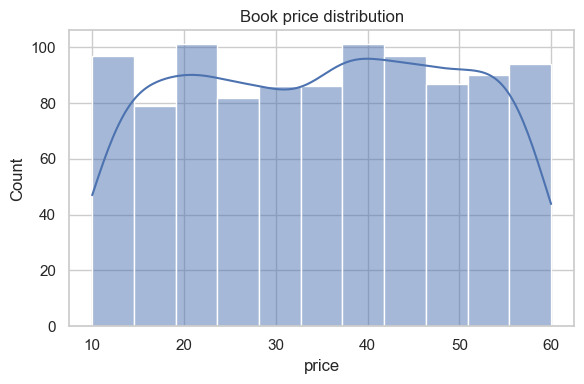

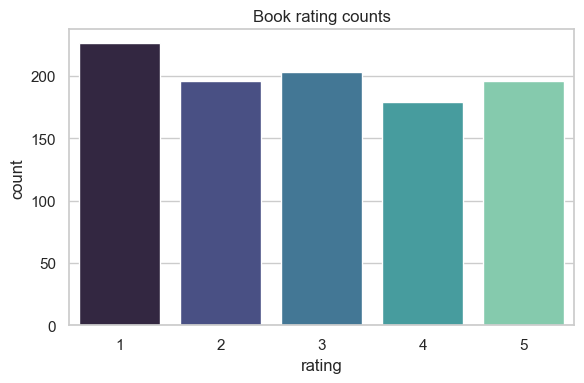

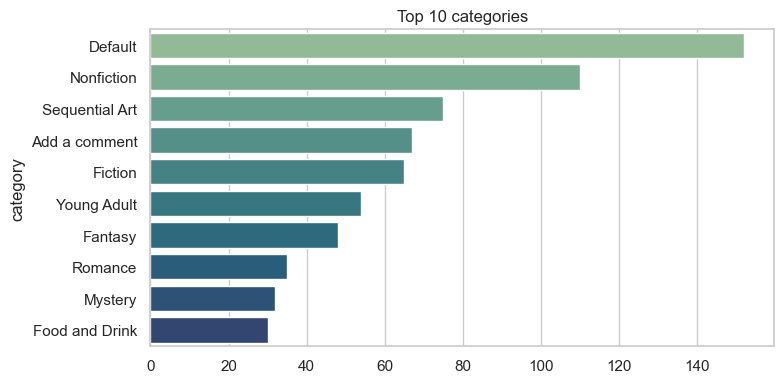

In [19]:
# Books visualizations
# Price distribution
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(books['price'], kde=True, ax=ax)
ax.set_title('Book price distribution')
save_fig(fig, 'books_price_hist.png')

# Rating distribution
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x='rating', data=books, palette='mako', ax=ax)
ax.set_title('Book rating counts')
save_fig(fig, 'books_rating_counts.png')

# Top categories
top_cats = books['category'].value_counts().nlargest(10)
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=top_cats.values, y=top_cats.index, palette='crest', ax=ax)
ax.set_title('Top 10 categories')
save_fig(fig, 'books_top_categories.png')


In [4]:
# Data cleaning
# Books: convert numeric fields, drop duplicates
before = books.shape[0]
books['price'] = pd.to_numeric(books['price'], errors='coerce')
books['rating'] = pd.to_numeric(books['rating'], errors='coerce')
books = books.drop_duplicates()
after = books.shape[0]
print(f'Books rows removed by duplicates: {before - after}')

# Fill or flag missing values
print('Books missing after conversions:\n', books.isna().sum())


Books rows removed by duplicates: 0
Books missing after conversions:
 title          0
price          0
rating         0
category       0
product_id     0
in_stock       0
stock_count    0
description    2
dtype: int64


In [5]:
# Additional preprocessing steps
# 1. Handle missing descriptions
books['description'] = books['description'].fillna('No description available')

# 2. Normalize text fields
books['title'] = books['title'].str.strip()
books['category'] = books['category'].str.strip()

# 3. Create derived features
books['title_length'] = books['title'].str.len()
books['has_description'] = books['description'] != 'No description available'

# 4. Encode categorical variables
from sklearn.preprocessing import LabelEncoder
le_category = LabelEncoder()
books['category_encoded'] = le_category.fit_transform(books['category'])

# 5. Convert boolean stock to numeric
books['in_stock_num'] = books['in_stock'].astype(int)

# 6. Create price bins for categorization
books['price_category'] = pd.cut(books['price'], 
                                   bins=[0, 20, 40, 60, float('inf')],
                                   labels=['Budget', 'Mid-range', 'Premium', 'Luxury'])

print('Preprocessing completed!')
print(f'Shape: {books.shape}')
print(f'\nNew columns: title_length, has_description, category_encoded, in_stock_num, price_category')
print(f'\nMissing values after preprocessing:\n{books.isna().sum()}')

Preprocessing completed!
Shape: (1000, 13)

New columns: title_length, has_description, category_encoded, in_stock_num, price_category

Missing values after preprocessing:
title               0
price               0
rating              0
category            0
product_id          0
in_stock            0
stock_count         0
description         0
title_length        0
has_description     0
category_encoded    0
in_stock_num        0
price_category      0
dtype: int64


In [20]:
# Save cleaned datasets
books.to_csv(PROC_DIR / 'books_data_clean.csv', index=False)
books.to_parquet(PROC_DIR / 'books_data_clean.parquet')
print('Saved cleaned book dataset to', PROC_DIR)


Saved cleaned book dataset to data\processed


In [6]:
# Model Training - Book Price Prediction
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Prepare feature sets
books_model = books.dropna(subset=['price', 'rating'])

# Feature set 1: Numeric features only
numeric_features = ['rating', 'stock_count', 'title_length', 'in_stock_num', 'category_encoded']
X = books_model[numeric_features]
y = books_model['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f'\n{"="*50}')
    print(f'Training {name}...')
    
    # Use scaled data for Linear Regression, raw for tree-based
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    cv_mae = -cv_scores.mean()
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'CV_MAE': cv_mae
    }
    
    print(f'MAE: {mae:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'R²: {r2:.3f}')
    print(f'CV MAE (5-fold): {cv_mae:.3f}')

# Display results summary
print(f'\n{"="*50}')
print('Model Performance Summary:')
print('='*50)
results_df = pd.DataFrame(results).T
print(results_df.round(3))

# Save best model (based on lowest MAE)
best_model_name = min(results, key=lambda x: results[x]['MAE'])
best_model = models[best_model_name]
print(f'\nBest model: {best_model_name}')

# Save model and scaler
joblib.dump(best_model, PROC_DIR / 'book_price_best_model.joblib')
joblib.dump(scaler, PROC_DIR / 'feature_scaler.joblib')
print(f'Saved {best_model_name} to {PROC_DIR / "book_price_best_model.joblib"}')


Training Linear Regression...
MAE: 12.713
RMSE: 14.582
R²: -0.012
CV MAE (5-fold): 12.503

Training Random Forest...
MAE: 13.201
RMSE: 15.250
R²: -0.107
CV MAE (5-fold): 12.825

Training Gradient Boosting...
MAE: 13.899
RMSE: 16.236
R²: -0.255
CV MAE (5-fold): 13.403

Model Performance Summary:
                      MAE    RMSE     R2  CV_MAE
Linear Regression  12.713  14.582 -0.012  12.503
Random Forest      13.201  15.250 -0.107  12.825
Gradient Boosting  13.899  16.236 -0.255  13.403

Best model: Linear Regression
Saved Linear Regression to data\processed\book_price_best_model.joblib


Saved figure: figures\feature_importance.png
Random Forest Top Features:
            feature  importance
2      title_length    0.387355
4  category_encoded    0.261878
1       stock_count    0.222148
0            rating    0.128619
3      in_stock_num    0.000000

Gradient Boosting Top Features:
            feature  importance
2      title_length    0.374898
4  category_encoded    0.246815
1       stock_count    0.230433
0            rating    0.147855
3      in_stock_num    0.000000


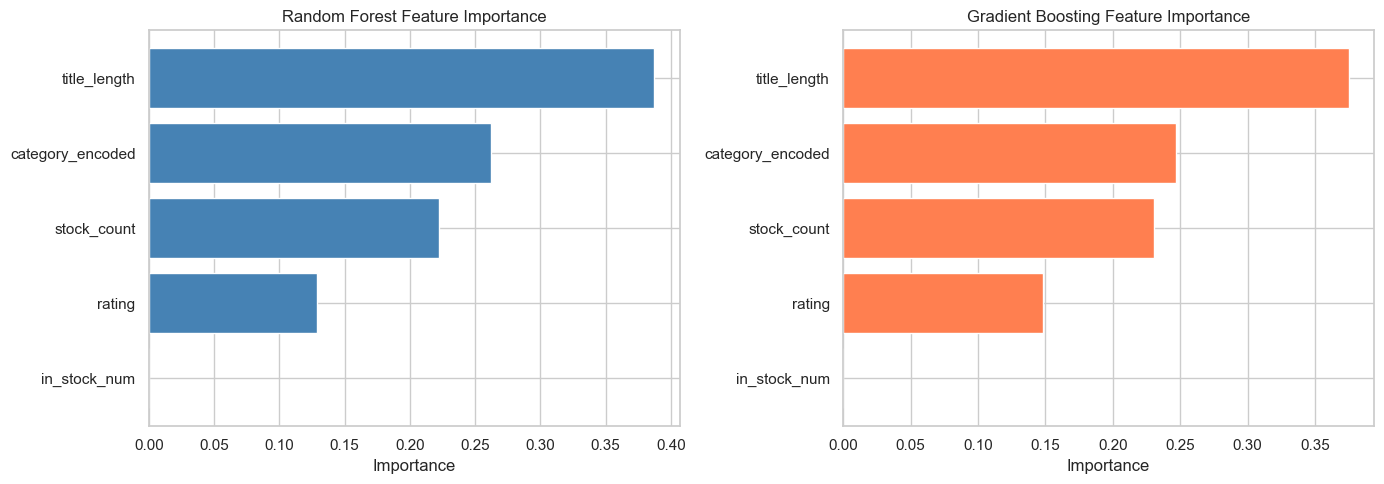

In [7]:
# Feature Importance Analysis
# For tree-based models, analyze feature importance
rf_model = models['Random Forest']
gb_model = models['Gradient Boosting']

# Get feature importance
rf_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

gb_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
axes[0].barh(rf_importance['feature'], rf_importance['importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Feature Importance')
axes[0].invert_yaxis()

# Gradient Boosting
axes[1].barh(gb_importance['feature'], gb_importance['importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting Feature Importance')
axes[1].invert_yaxis()

save_fig(fig, 'feature_importance.png')

print('Random Forest Top Features:')
print(rf_importance)
print('\nGradient Boosting Top Features:')
print(gb_importance)

Saved figure: figures\model_predictions.png
Generated prediction visualizations for Linear Regression


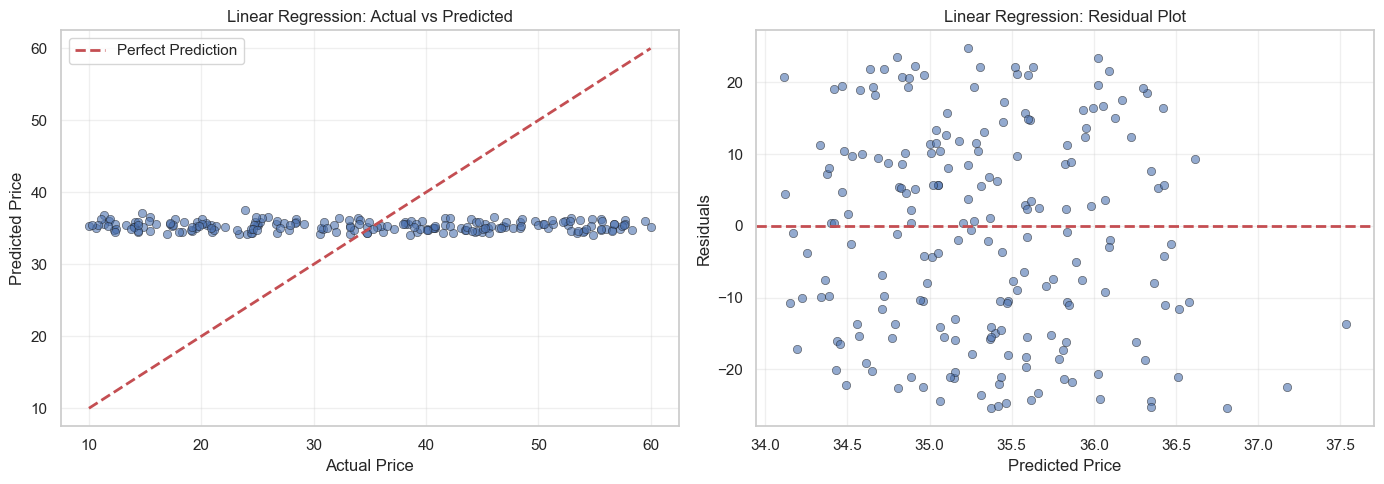

In [8]:
# Model Predictions Visualization
# Plot actual vs predicted for the best model
best_model_preds = best_model.predict(X_test if best_model_name != 'Linear Regression' else X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, best_model_preds, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - best_model_preds
axes[1].scatter(best_model_preds, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{best_model_name}: Residual Plot')
axes[1].grid(True, alpha=0.3)

save_fig(fig, 'model_predictions.png')
print(f'Generated prediction visualizations for {best_model_name}')

## Model Evaluation & Comparison

In [9]:
# Comprehensive Evaluation Metrics
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, explained_variance_score
import json

# Calculate additional metrics for all models
detailed_metrics = {}

for name, model in models.items():
    # Get predictions
    if name == 'Linear Regression':
        train_preds = model.predict(X_train_scaled)
        test_preds = model.predict(X_test_scaled)
    else:
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
    
    # Calculate comprehensive metrics
    detailed_metrics[name] = {
        # Test metrics
        'Test MAE': mean_absolute_error(y_test, test_preds),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, test_preds)),
        'Test R²': r2_score(y_test, test_preds),
        'Test MAPE (%)': mean_absolute_percentage_error(y_test, test_preds) * 100,
        'Test MedAE': median_absolute_error(y_test, test_preds),
        'Test Explained Var': explained_variance_score(y_test, test_preds),
        # Training metrics
        'Train MAE': mean_absolute_error(y_train, train_preds),
        'Train R²': r2_score(y_train, train_preds),
    }
    
    # Calculate overfitting indicator
    detailed_metrics[name]['Overfit Gap (R²)'] = detailed_metrics[name]['Train R²'] - detailed_metrics[name]['Test R²']

# Create comprehensive metrics DataFrame
eval_df = pd.DataFrame(detailed_metrics).T
print('='*80)
print('COMPREHENSIVE MODEL EVALUATION METRICS')
print('='*80)
print(eval_df.round(4))

# Save evaluation metrics
eval_df.to_csv(PROC_DIR / 'model_evaluation_metrics.csv')
eval_dict = {name: {k: float(v) for k, v in metrics.items()} for name, metrics in detailed_metrics.items()}
with open(PROC_DIR / 'evaluation_metrics.json', 'w') as f:
    json.dump(eval_dict, f, indent=2)
print(f'\nMetrics saved to {PROC_DIR}')

COMPREHENSIVE MODEL EVALUATION METRICS
                   Test MAE  Test RMSE  Test R²  Test MAPE (%)  Test MedAE  \
Linear Regression   12.7134    14.5816  -0.0122        53.9770     12.0884   
Random Forest       13.2011    15.2499  -0.1071        55.6497     12.9552   
Gradient Boosting   13.8992    16.2365  -0.2550        58.7282     12.9457   

                   Test Explained Var  Train MAE  Train R²  Overfit Gap (R²)  
Linear Regression             -0.0065    12.4647    0.0021            0.0143  
Random Forest                 -0.1014     8.5060    0.5180            0.6251  
Gradient Boosting             -0.2413     7.4360    0.6034            0.8584  

Metrics saved to data\processed


Saved figure: figures\model_comparison.png
Model comparison visualization complete!


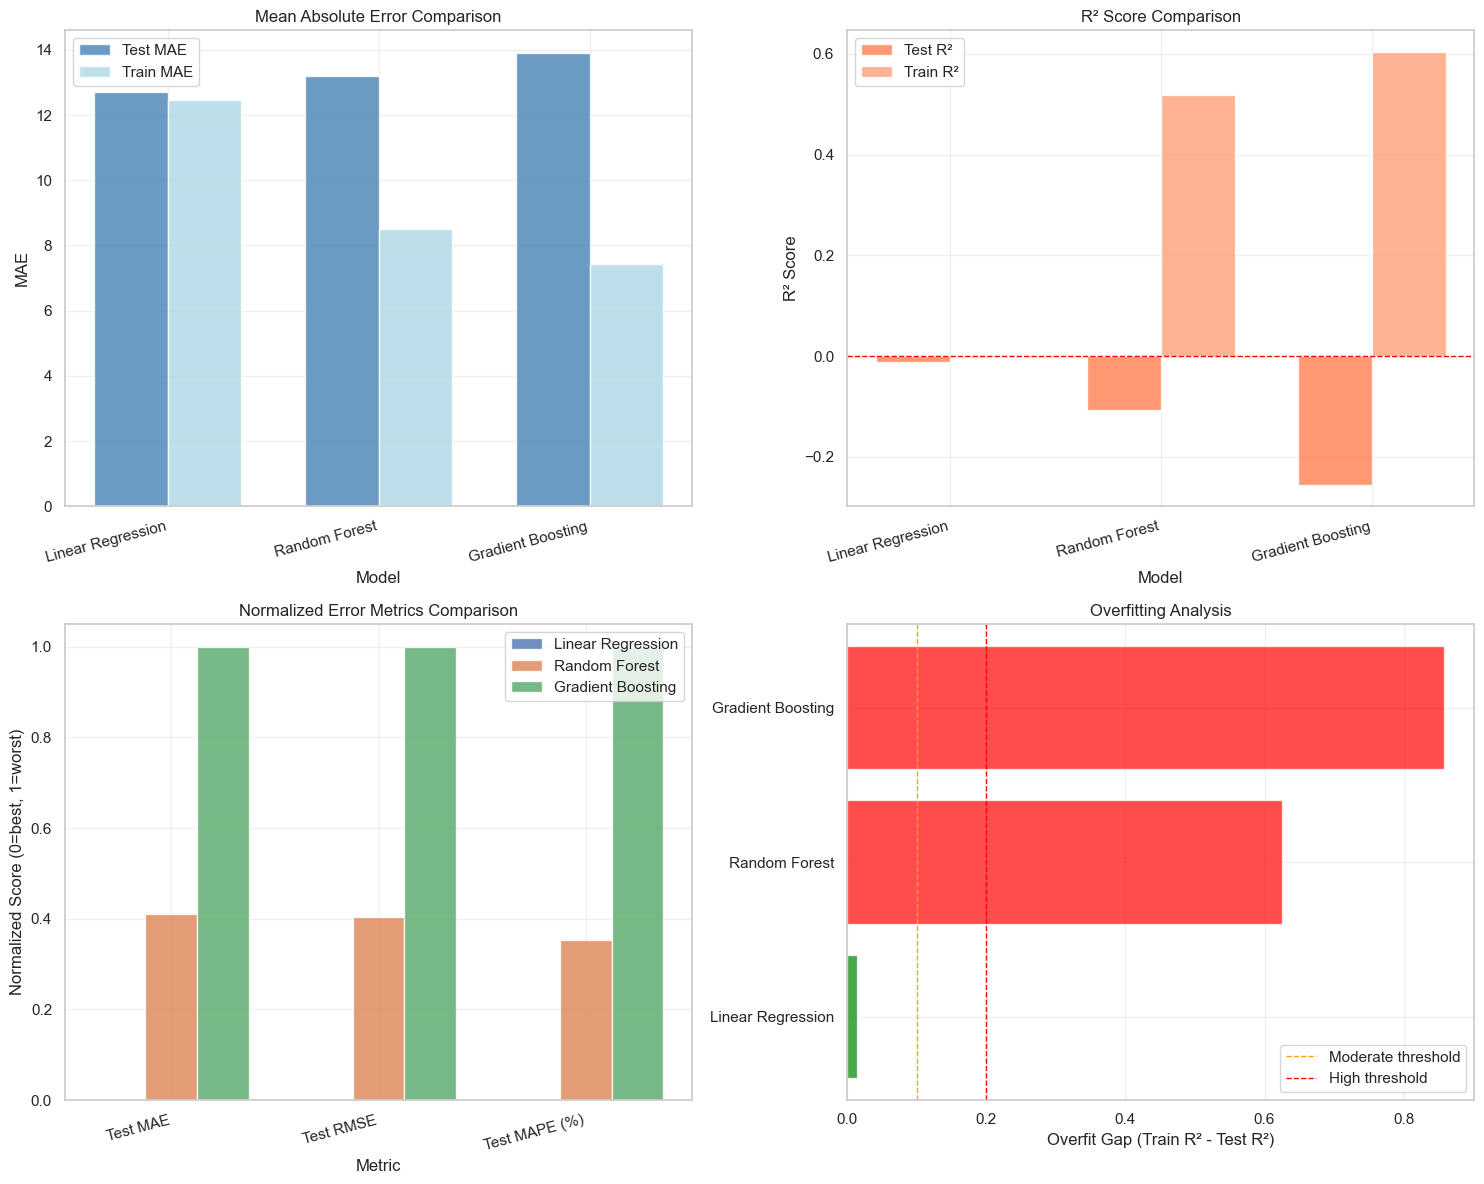

In [10]:
# Model Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. MAE Comparison
metrics_to_plot = ['Test MAE', 'Train MAE']
mae_data = eval_df[metrics_to_plot]
x_pos = np.arange(len(mae_data.index))
width = 0.35
axes[0, 0].bar(x_pos - width/2, mae_data['Test MAE'], width, label='Test MAE', color='steelblue', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, mae_data['Train MAE'], width, label='Train MAE', color='lightblue', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_title('Mean Absolute Error Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(mae_data.index, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. R² Score Comparison
r2_data = eval_df[['Test R²', 'Train R²']]
axes[0, 1].bar(x_pos - width/2, r2_data['Test R²'], width, label='Test R²', color='coral', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, r2_data['Train R²'], width, label='Train R²', color='lightsalmon', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² Score Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(r2_data.index, rotation=15, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)

# 3. Multiple Metrics Radar/Bar Chart
test_metrics = eval_df[['Test MAE', 'Test RMSE', 'Test MAPE (%)']].copy()
# Normalize for visualization (0-1 scale, lower is better)
test_metrics_norm = (test_metrics - test_metrics.min()) / (test_metrics.max() - test_metrics.min())
x_metrics = np.arange(len(test_metrics.columns))
width_multi = 0.25
for i, model_name in enumerate(test_metrics_norm.index):
    axes[1, 0].bar(x_metrics + i*width_multi, test_metrics_norm.loc[model_name], 
                   width_multi, label=model_name, alpha=0.8)
axes[1, 0].set_xlabel('Metric')
axes[1, 0].set_ylabel('Normalized Score (0=best, 1=worst)')
axes[1, 0].set_title('Normalized Error Metrics Comparison')
axes[1, 0].set_xticks(x_metrics + width_multi)
axes[1, 0].set_xticklabels(test_metrics.columns, rotation=15, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Overfitting Analysis
overfit_data = eval_df['Overfit Gap (R²)']
colors = ['green' if x < 0.1 else 'orange' if x < 0.2 else 'red' for x in overfit_data]
axes[1, 1].barh(overfit_data.index, overfit_data, color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Overfit Gap (Train R² - Test R²)')
axes[1, 1].set_title('Overfitting Analysis')
axes[1, 1].axvline(x=0.1, color='orange', linestyle='--', linewidth=1, label='Moderate threshold')
axes[1, 1].axvline(x=0.2, color='red', linestyle='--', linewidth=1, label='High threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

save_fig(fig, 'model_comparison.png')
print('Model comparison visualization complete!')

Running 5-fold CV for Linear Regression...
Running 5-fold CV for Random Forest...
Running 5-fold CV for Gradient Boosting...

CROSS-VALIDATION RESULTS (5-Fold)
                           CV MAE           CV R²         CV RMSE
Linear Regression  12.576 ± 0.268  -0.020 ± 0.011  14.541 ± 0.287
Random Forest      12.857 ± 0.417  -0.086 ± 0.039  15.006 ± 0.441
Gradient Boosting  13.374 ± 0.611  -0.211 ± 0.084  15.842 ± 0.716


C:\Users\Millpark\AppData\Local\Temp\ipykernel_15240\1904936402.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(mae_scores_data, labels=models.keys(), patch_artist=True)
C:\Users\Millpark\AppData\Local\Temp\ipykernel_15240\1904936402.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(r2_scores_data, labels=models.keys(), patch_artist=True)


Saved figure: figures\cross_validation_results.png

Cross-validation analysis complete!


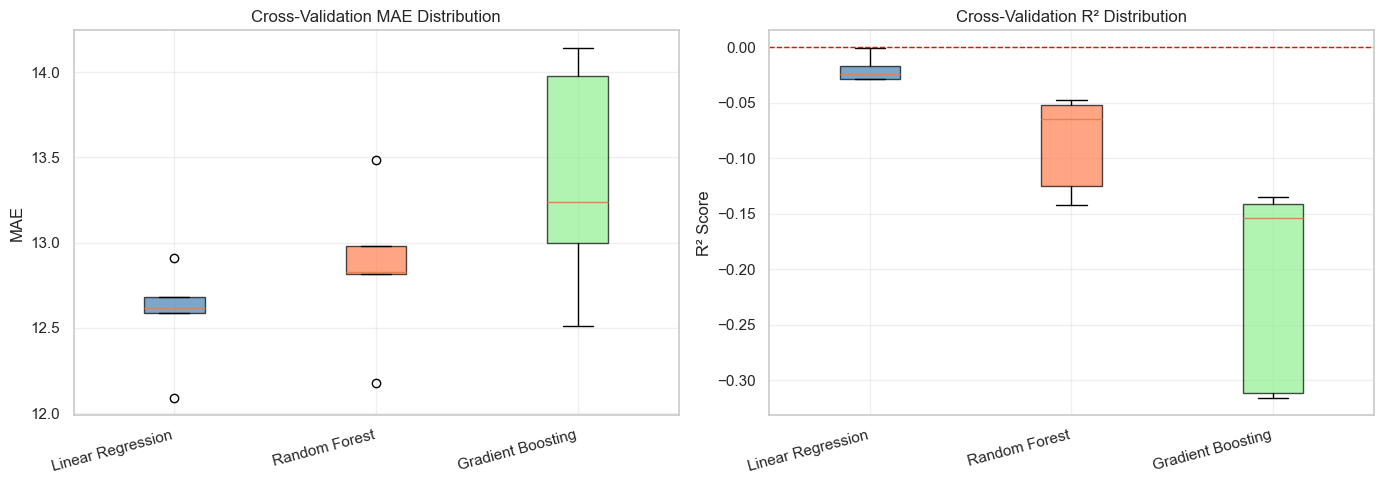

In [11]:
# Cross-Validation Analysis
from sklearn.model_selection import KFold

cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

cv_results = {}
for name, model in models.items():
    print(f'Running {cv_folds}-fold CV for {name}...')
    
    # Use appropriate data
    X_data = X_train_scaled if name == 'Linear Regression' else X_train
    
    # Perform cross-validation with multiple metrics
    mae_scores = cross_val_score(model, X_data, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X_data, y_train, cv=kfold, scoring='r2')
    rmse_scores = cross_val_score(model, X_data, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    
    cv_results[name] = {
        'MAE_mean': -mae_scores.mean(),
        'MAE_std': mae_scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std(),
        'RMSE_mean': -rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'MAE_scores': -mae_scores,
        'R2_scores': r2_scores
    }

# Display CV results
cv_summary = pd.DataFrame({
    name: {
        'CV MAE': f"{res['MAE_mean']:.3f} ± {res['MAE_std']:.3f}",
        'CV R²': f"{res['R2_mean']:.3f} ± {res['R2_std']:.3f}",
        'CV RMSE': f"{res['RMSE_mean']:.3f} ± {res['RMSE_std']:.3f}"
    }
    for name, res in cv_results.items()
}).T

print('\n' + '='*60)
print('CROSS-VALIDATION RESULTS (5-Fold)')
print('='*60)
print(cv_summary)

# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot for MAE scores across folds
mae_scores_data = [cv_results[name]['MAE_scores'] for name in models.keys()]
bp1 = axes[0].boxplot(mae_scores_data, labels=models.keys(), patch_artist=True)
for patch, color in zip(bp1['boxes'], ['steelblue', 'coral', 'lightgreen']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_ylabel('MAE')
axes[0].set_title('Cross-Validation MAE Distribution')
axes[0].set_xticklabels(models.keys(), rotation=15, ha='right')
axes[0].grid(True, alpha=0.3)

# Box plot for R² scores across folds
r2_scores_data = [cv_results[name]['R2_scores'] for name in models.keys()]
bp2 = axes[1].boxplot(r2_scores_data, labels=models.keys(), patch_artist=True)
for patch, color in zip(bp2['boxes'], ['steelblue', 'coral', 'lightgreen']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('R² Score')
axes[1].set_title('Cross-Validation R² Distribution')
axes[1].set_xticklabels(models.keys(), rotation=15, ha='right')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)

save_fig(fig, 'cross_validation_results.png')
print('\nCross-validation analysis complete!')

C:\Users\Millpark\AppData\Local\Temp\ipykernel_15240\2090639293.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[4].boxplot([error_comparison[col] for col in error_comparison.columns],


Saved figure: figures\error_analysis.png
Error distribution analysis complete!


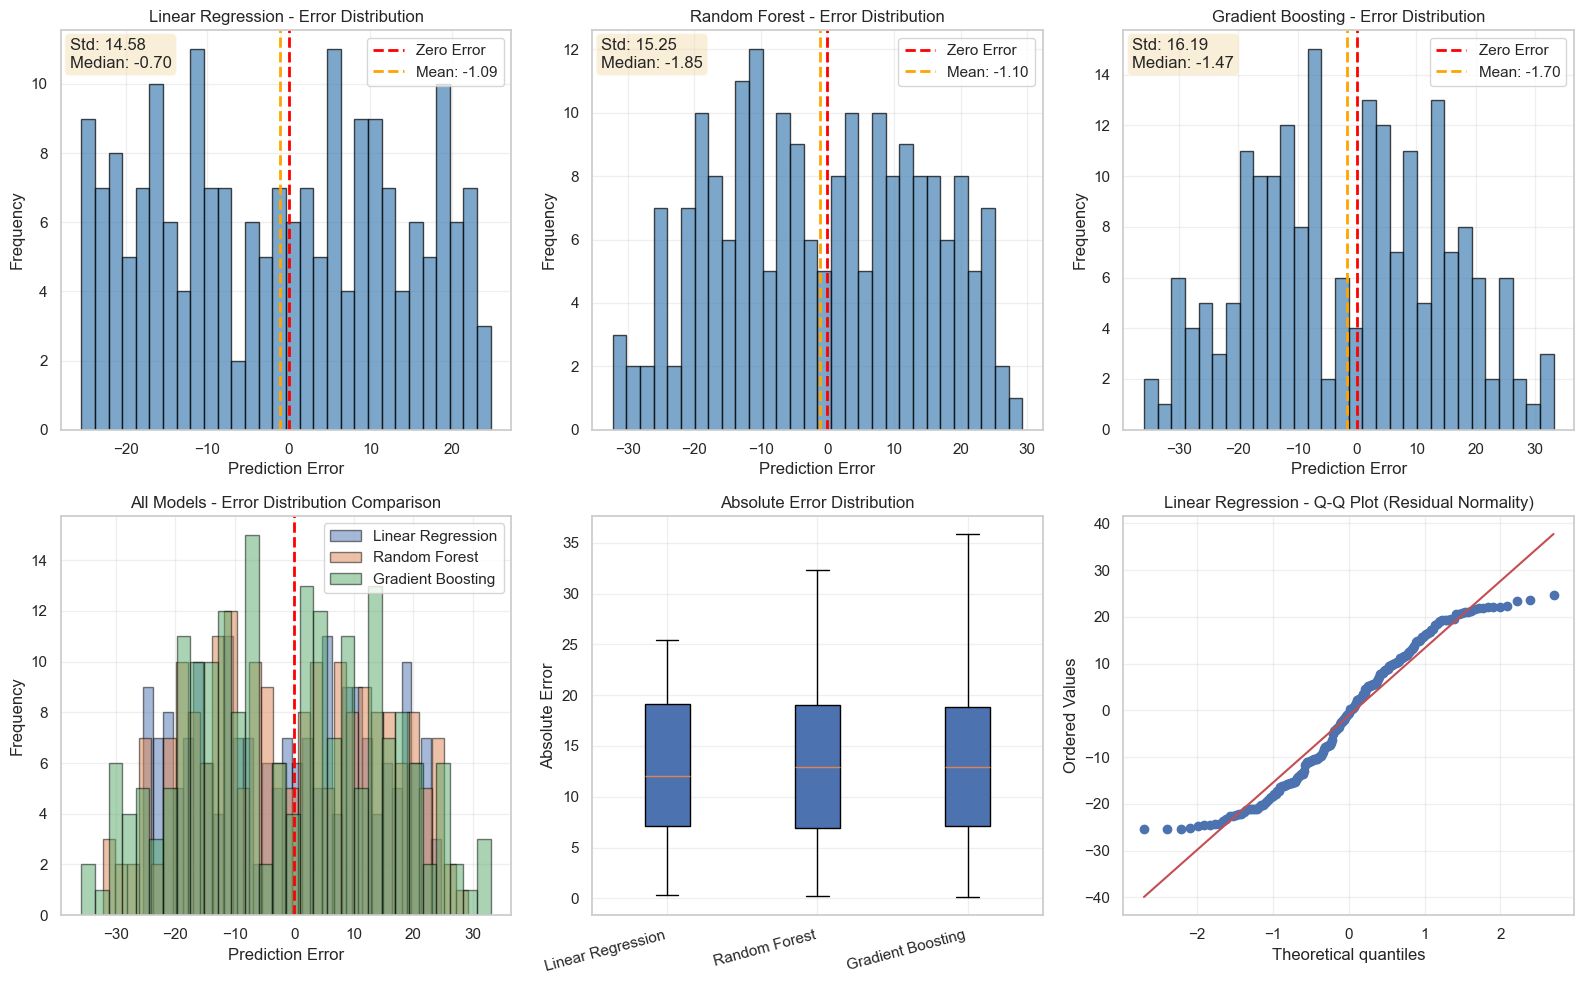

In [12]:
# Error Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    # Get predictions
    if name == 'Linear Regression':
        test_preds = model.predict(X_test_scaled)
    else:
        test_preds = model.predict(X_test)
    
    # Calculate errors
    errors = y_test - test_preds
    abs_errors = np.abs(errors)
    
    # Histogram of errors
    axes[idx].hist(errors, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[idx].axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
    axes[idx].set_xlabel('Prediction Error')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{name} - Error Distribution')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f'Std: {errors.std():.2f}\nMedian: {np.median(errors):.2f}'
    axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Comparative error distribution (all models)
for name, model in models.items():
    if name == 'Linear Regression':
        test_preds = model.predict(X_test_scaled)
    else:
        test_preds = model.predict(X_test)
    errors = y_test - test_preds
    axes[3].hist(errors, bins=30, alpha=0.5, label=name, edgecolor='black')

axes[3].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[3].set_xlabel('Prediction Error')
axes[3].set_ylabel('Frequency')
axes[3].set_title('All Models - Error Distribution Comparison')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# Absolute error comparison
error_comparison = pd.DataFrame({
    name: np.abs(y_test - (model.predict(X_test_scaled) if name == 'Linear Regression' else model.predict(X_test)))
    for name, model in models.items()
})

axes[4].boxplot([error_comparison[col] for col in error_comparison.columns], 
                labels=error_comparison.columns, patch_artist=True)
axes[4].set_ylabel('Absolute Error')
axes[4].set_title('Absolute Error Distribution')
axes[4].set_xticklabels(error_comparison.columns, rotation=15, ha='right')
axes[4].grid(True, alpha=0.3)

# Q-Q plot for best model (normality check of residuals)
from scipy import stats
best_errors = y_test - best_model_preds
stats.probplot(best_errors, dist="norm", plot=axes[5])
axes[5].set_title(f'{best_model_name} - Q-Q Plot (Residual Normality)')
axes[5].grid(True, alpha=0.3)

save_fig(fig, 'error_analysis.png')
print('Error distribution analysis complete!')

In [13]:
# Final Evaluation Summary
print('='*80)
print('FINAL EVALUATION SUMMARY')
print('='*80)
print(f'\n📊 Dataset: {len(books_model)} books')
print(f'📈 Features used: {", ".join(numeric_features)}')
print(f'🔄 Train/Test split: {len(X_train)}/{len(X_test)} ({100*(1-0.2):.0f}%/{100*0.2:.0f}%)')

print(f'\n🏆 BEST MODEL: {best_model_name}')
print(f'   • Test MAE: ${detailed_metrics[best_model_name]["Test MAE"]:.2f}')
print(f'   • Test RMSE: ${detailed_metrics[best_model_name]["Test RMSE"]:.2f}')
print(f'   • Test R²: {detailed_metrics[best_model_name]["Test R²"]:.4f}')
print(f'   • Test MAPE: {detailed_metrics[best_model_name]["Test MAPE (%)"]:.2f}%')
print(f'   • CV MAE: ${cv_results[best_model_name]["MAE_mean"]:.2f} ± ${cv_results[best_model_name]["MAE_std"]:.2f}')

print('\n📋 MODEL RANKINGS (by Test MAE):')
ranking = eval_df[['Test MAE', 'Test R²', 'Test MAPE (%)']].sort_values('Test MAE')
for idx, (model_name, row) in enumerate(ranking.iterrows(), 1):
    print(f'   {idx}. {model_name:20s} - MAE: ${row["Test MAE"]:.2f}, R²: {row["Test R²"]:.4f}, MAPE: {row["Test MAPE (%)"]:.2f}%')

print('\n🎯 KEY INSIGHTS:')
# Check for overfitting
overfit_models = eval_df[eval_df['Overfit Gap (R²)'] > 0.1].index.tolist()
if overfit_models:
    print(f'   ⚠️  Potential overfitting detected: {", ".join(overfit_models)}')
else:
    print('   ✅ No significant overfitting detected')

# Check model performance
if detailed_metrics[best_model_name]['Test R²'] < 0:
    print('   ⚠️  Negative R² indicates models perform worse than baseline (mean prediction)')
    print('   💡 Consider: feature engineering, more data, or different algorithms')
else:
    print(f'   ✅ Best model explains {detailed_metrics[best_model_name]["Test R²"]*100:.2f}% of price variance')

# Feature importance reminder
print(f'\n🔑 TOP 3 IMPORTANT FEATURES (from Random Forest):')
top_features = rf_importance.head(3)
for idx, row in top_features.iterrows():
    print(f'   {idx+1}. {row["feature"]:20s} - {row["importance"]:.3f}')

print(f'\n💾 SAVED ARTIFACTS:')
print(f'   • Best model: {PROC_DIR / "book_price_best_model.joblib"}')
print(f'   • Feature scaler: {PROC_DIR / "feature_scaler.joblib"}')
print(f'   • Evaluation metrics: {PROC_DIR / "model_evaluation_metrics.csv"}')
print(f'   • Visualizations: {FIG_DIR}/')

print('\n' + '='*80)

FINAL EVALUATION SUMMARY

📊 Dataset: 1000 books
📈 Features used: rating, stock_count, title_length, in_stock_num, category_encoded
🔄 Train/Test split: 800/200 (80%/20%)

🏆 BEST MODEL: Linear Regression
   • Test MAE: $12.71
   • Test RMSE: $14.58
   • Test R²: -0.0122
   • Test MAPE: 53.98%
   • CV MAE: $12.58 ± $0.27

📋 MODEL RANKINGS (by Test MAE):
   1. Linear Regression    - MAE: $12.71, R²: -0.0122, MAPE: 53.98%
   2. Random Forest        - MAE: $13.20, R²: -0.1071, MAPE: 55.65%
   3. Gradient Boosting    - MAE: $13.90, R²: -0.2550, MAPE: 58.73%

🎯 KEY INSIGHTS:
   ⚠️  Potential overfitting detected: Random Forest, Gradient Boosting
   ⚠️  Negative R² indicates models perform worse than baseline (mean prediction)
   💡 Consider: feature engineering, more data, or different algorithms

🔑 TOP 3 IMPORTANT FEATURES (from Random Forest):
   3. title_length         - 0.387
   5. category_encoded     - 0.262
   2. stock_count          - 0.222

💾 SAVED ARTIFACTS:
   • Best model: data\proc

## Model Deployment

In [14]:
# Create Prediction Pipeline Class
class BookPricePredictor:
    """Production-ready book price prediction pipeline."""
    
    def __init__(self, model_path=None, scaler_path=None, encoder_path=None):
        """Initialize the predictor with saved artifacts."""
        self.model_path = model_path or PROC_DIR / 'book_price_best_model.joblib'
        self.scaler_path = scaler_path or PROC_DIR / 'feature_scaler.joblib'
        self.encoder_path = encoder_path
        
        # Load model and scaler
        self.model = joblib.load(self.model_path)
        self.scaler = joblib.load(self.scaler_path)
        self.le_category = le_category  # Use the fitted encoder from training
        
        # Feature configuration
        self.numeric_features = ['rating', 'stock_count', 'title_length', 'in_stock_num', 'category_encoded']
        self.required_fields = ['title', 'rating', 'category', 'stock_count', 'in_stock']
        
        print(f'✅ Model loaded from: {self.model_path}')
        print(f'✅ Scaler loaded from: {self.scaler_path}')
        print(f'✅ Model type: {type(self.model).__name__}')
    
    def preprocess(self, data):
        """Preprocess input data for prediction."""
        df = pd.DataFrame([data]) if isinstance(data, dict) else data.copy()
        
        # Validate required fields
        missing_fields = [f for f in self.required_fields if f not in df.columns]
        if missing_fields:
            raise ValueError(f'Missing required fields: {missing_fields}')
        
        # Feature engineering (same as training)
        df['title_length'] = df['title'].str.len()
        df['in_stock_num'] = df['in_stock'].astype(int)
        
        # Encode category
        try:
            df['category_encoded'] = self.le_category.transform(df['category'])
        except ValueError as e:
            # Handle unseen categories
            print(f'⚠️  Warning: Unknown category encountered, using default encoding')
            df['category_encoded'] = 0
        
        # Select features
        X = df[self.numeric_features]
        
        # Scale features
        X_scaled = self.scaler.transform(X)
        
        return X_scaled
    
    def predict(self, data):
        """Make price predictions on new data."""
        X_processed = self.preprocess(data)
        predictions = self.model.predict(X_processed)
        return predictions
    
    def predict_single(self, title, rating, category, stock_count, in_stock):
        """Convenience method for single book prediction."""
        data = {
            'title': title,
            'rating': rating,
            'category': category,
            'stock_count': stock_count,
            'in_stock': in_stock
        }
        return self.predict(data)[0]
    
    def predict_with_confidence(self, data):
        """Predict with confidence intervals (for ensemble models)."""
        predictions = self.predict(data)
        
        # Calculate simple confidence based on MAE
        mae = detailed_metrics[best_model_name]['Test MAE']
        
        results = []
        for pred in predictions:
            results.append({
                'predicted_price': round(pred, 2),
                'lower_bound': round(pred - mae, 2),
                'upper_bound': round(pred + mae, 2),
                'confidence_interval': f'±${mae:.2f}'
            })
        
        return results

# Initialize predictor
predictor = BookPricePredictor()
print('\n🚀 Predictor ready for deployment!')

✅ Model loaded from: data\processed\book_price_best_model.joblib
✅ Scaler loaded from: data\processed\feature_scaler.joblib
✅ Model type: LinearRegression

🚀 Predictor ready for deployment!


In [16]:
# Test Prediction Pipeline
print('='*70)
print('TESTING PREDICTION PIPELINE')
print('='*70)

# Test Case 1: Single book prediction
print('\n📚 Test Case 1: Single Book Prediction')
test_book = {
    'title': 'Introduction to Machine Learning',
    'rating': 4.5,
    'category': 'Science',
    'stock_count': 15,
    'in_stock': True
}

predicted_price = predictor.predict_single(
    title=test_book['title'],
    rating=test_book['rating'],
    category=test_book['category'],
    stock_count=test_book['stock_count'],
    in_stock=test_book['in_stock']
)

print(f'   Book: {test_book["title"]}')
print(f'   Rating: {test_book["rating"]}')
print(f'   Category: {test_book["category"]}')
print(f'   Stock: {test_book["stock_count"]} (in stock: {test_book["in_stock"]})')
print(f'   ➡️  Predicted Price: ${predicted_price:.2f}')

# Test Case 2: Batch prediction with confidence
print('\n📚 Test Case 2: Batch Prediction with Confidence Intervals')
test_books = pd.DataFrame([
    {'title': 'Python for Data Science', 'rating': 4.8, 'category': 'Science', 'stock_count': 25, 'in_stock': True},
    {'title': 'The Great Novel', 'rating': 4.2, 'category': 'Fiction', 'stock_count': 5, 'in_stock': False},
    {'title': 'History of Europe', 'rating': 3.9, 'category': 'History', 'stock_count': 10, 'in_stock': True},
])

predictions_with_ci = predictor.predict_with_confidence(test_books)

for i, (_, book) in enumerate(test_books.iterrows()):
    pred = predictions_with_ci[i]
    print(f'\n   {i+1}. "{book["title"]}" ({book["category"]})')
    print(f'      Rating: {book["rating"]} | Stock: {book["stock_count"]}')
    print(f'      💰 Predicted: ${pred["predicted_price"]} [{pred["lower_bound"]} - {pred["upper_bound"]}]')
    print(f'      📊 Confidence: {pred["confidence_interval"]}')

# Test Case 3: Compare with actual prices from test set
print('\n📚 Test Case 3: Real Data Validation')
sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_y = y_test.iloc[sample_indices]

# Get book details from original dataframe
sample_books = books_model.iloc[y_test.index[sample_indices]][['title', 'rating', 'category', 'stock_count', 'in_stock']]

predictions = predictor.predict(sample_books)

print(f'   Comparing predictions vs actual prices on {len(sample_indices)} random test samples:')
for i, (pred, actual, (idx, book)) in enumerate(zip(predictions, sample_y, sample_books.iterrows())):
    error = abs(pred - actual)
    print(f'\n   {i+1}. "{book["title"][:40]}..."')
    print(f'      Predicted: ${pred:.2f} | Actual: ${actual:.2f} | Error: ${error:.2f}')

print('\n' + '='*70)

TESTING PREDICTION PIPELINE

📚 Test Case 1: Single Book Prediction
   Book: Introduction to Machine Learning
   Rating: 4.5
   Category: Science
   Stock: 15 (in stock: True)
   ➡️  Predicted Price: $35.73

📚 Test Case 2: Batch Prediction with Confidence Intervals

   1. "Python for Data Science" (Science)
      Rating: 4.8 | Stock: 25
      💰 Predicted: $35.74 [23.03 - 48.46]
      📊 Confidence: ±$12.71

   2. "The Great Novel" (Fiction)
      Rating: 4.2 | Stock: 5
      💰 Predicted: $35.39 [22.68 - 48.1]
      📊 Confidence: ±$12.71

   3. "History of Europe" (History)
      Rating: 3.9 | Stock: 10
      💰 Predicted: $35.31 [22.6 - 48.03]
      📊 Confidence: ±$12.71

📚 Test Case 3: Real Data Validation
   Comparing predictions vs actual prices on 5 random test samples:

   1. "The Catcher in the Rye..."
      Predicted: $34.39 | Actual: $24.55 | Error: $9.84

   2. "Tell the Wind and Fire..."
      Predicted: $35.07 | Actual: $45.51 | Error: $10.44

   3. "I Know What Im Doing -- and

In [17]:
# Save Deployment Artifacts
import pickle

# Save the category encoder
encoder_path = PROC_DIR / 'category_encoder.joblib'
joblib.dump(le_category, encoder_path)

# Save deployment metadata
deployment_metadata = {
    'model_type': type(best_model).__name__,
    'model_version': '1.0.0',
    'training_date': '2026-01-13',
    'features': numeric_features,
    'required_inputs': ['title', 'rating', 'category', 'stock_count', 'in_stock'],
    'performance': {
        'test_mae': float(detailed_metrics[best_model_name]['Test MAE']),
        'test_rmse': float(detailed_metrics[best_model_name]['Test RMSE']),
        'test_r2': float(detailed_metrics[best_model_name]['Test R²']),
        'cv_mae_mean': float(cv_results[best_model_name]['MAE_mean']),
        'cv_mae_std': float(cv_results[best_model_name]['MAE_std'])
    },
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'unique_categories': le_category.classes_.tolist()
}

metadata_path = PROC_DIR / 'deployment_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(deployment_metadata, f, indent=2)

print('='*70)
print('DEPLOYMENT ARTIFACTS SAVED')
print('='*70)
print(f'\n📦 Deployment Package Contents:')
print(f'   1. Model:               {PROC_DIR / "book_price_best_model.joblib"}')
print(f'   2. Feature Scaler:      {PROC_DIR / "feature_scaler.joblib"}')
print(f'   3. Category Encoder:    {encoder_path}')
print(f'   4. Deployment Metadata: {metadata_path}')
print(f'   5. Evaluation Metrics:  {PROC_DIR / "model_evaluation_metrics.csv"}')
print(f'   6. Cleaned Data:        {PROC_DIR / "books_data_clean.parquet"}')

print(f'\n📊 Model Information:')
print(f'   • Type: {deployment_metadata["model_type"]}')
print(f'   • Version: {deployment_metadata["model_version"]}')
print(f'   • Test MAE: ${deployment_metadata["performance"]["test_mae"]:.2f}')
print(f'   • Categories Supported: {len(deployment_metadata["unique_categories"])}')

print('\n' + '='*70)

DEPLOYMENT ARTIFACTS SAVED

📦 Deployment Package Contents:
   1. Model:               data\processed\book_price_best_model.joblib
   2. Feature Scaler:      data\processed\feature_scaler.joblib
   3. Category Encoder:    data\processed\category_encoder.joblib
   4. Deployment Metadata: data\processed\deployment_metadata.json
   5. Evaluation Metrics:  data\processed\model_evaluation_metrics.csv
   6. Cleaned Data:        data\processed\books_data_clean.parquet

📊 Model Information:
   • Type: LinearRegression
   • Version: 1.0.0
   • Test MAE: $12.71
   • Categories Supported: 50



In [18]:
# Create Deployment Script
deployment_script = '''#!/usr/bin/env python3
"""
Book Price Prediction API
Production deployment script for the trained model.
"""

import joblib
import pandas as pd
import numpy as np
from pathlib import Path
import json

class BookPricePredictor:
    """Production-ready book price prediction pipeline."""
    
    def __init__(self, model_dir='data/processed'):
        """Initialize predictor with saved artifacts."""
        self.model_dir = Path(model_dir)
        
        # Load artifacts
        self.model = joblib.load(self.model_dir / 'book_price_best_model.joblib')
        self.scaler = joblib.load(self.model_dir / 'feature_scaler.joblib')
        self.encoder = joblib.load(self.model_dir / 'category_encoder.joblib')
        
        # Load metadata
        with open(self.model_dir / 'deployment_metadata.json', 'r') as f:
            self.metadata = json.load(f)
        
        self.numeric_features = self.metadata['features']
        self.required_fields = self.metadata['required_inputs']
        
        print(f'Model loaded: {self.metadata["model_type"]} v{self.metadata["model_version"]}')
        print(f'Test MAE: ${self.metadata["performance"]["test_mae"]:.2f}')
    
    def preprocess(self, data):
        """Preprocess input data."""
        df = pd.DataFrame([data]) if isinstance(data, dict) else data.copy()
        
        # Validate
        missing = [f for f in self.required_fields if f not in df.columns]
        if missing:
            raise ValueError(f'Missing fields: {missing}')
        
        # Feature engineering
        df['title_length'] = df['title'].str.len()
        df['in_stock_num'] = df['in_stock'].astype(int)
        
        # Encode category
        try:
            df['category_encoded'] = self.encoder.transform(df['category'])
        except ValueError:
            print('Warning: Unknown category, using default')
            df['category_encoded'] = 0
        
        # Select and scale
        X = df[self.numeric_features]
        return self.scaler.transform(X)
    
    def predict(self, data):
        """Make predictions."""
        X = self.preprocess(data)
        return self.model.predict(X)
    
    def predict_with_confidence(self, data):
        """Predict with confidence interval."""
        predictions = self.predict(data)
        mae = self.metadata['performance']['test_mae']
        
        return [{
            'predicted_price': float(round(p, 2)),
            'lower_bound': float(round(p - mae, 2)),
            'upper_bound': float(round(p + mae, 2)),
            'mae': mae
        } for p in predictions]

# Example usage
if __name__ == '__main__':
    # Initialize predictor
    predictor = BookPricePredictor()
    
    # Example prediction
    book = {
        'title': 'Introduction to Python Programming',
        'rating': 4.5,
        'category': 'Science',
        'stock_count': 20,
        'in_stock': True
    }
    
    result = predictor.predict_with_confidence(book)
    print(f'\\nPrediction for "{book["title"]}":')
    print(f'  Price: ${result[0]["predicted_price"]}')
    print(f'  Range: ${result[0]["lower_bound"]} - ${result[0]["upper_bound"]}')
'''

# Save deployment script
script_path = Path('deploy_model.py')
with open(script_path, 'w') as f:
    f.write(deployment_script)

print(f'✅ Deployment script created: {script_path}')
print(f'   Run with: python {script_path}')

✅ Deployment script created: deploy_model.py
   Run with: python deploy_model.py


### Deployment Documentation

#### 📦 Quick Start

To use the trained model in production:

```python
from deploy_model import BookPricePredictor

# Initialize predictor
predictor = BookPricePredictor(model_dir='data/processed')

# Make prediction
book = {
    'title': 'Your Book Title',
    'rating': 4.5,
    'category': 'Science',
    'stock_count': 20,
    'in_stock': True
}

result = predictor.predict_with_confidence(book)
print(f"Predicted Price: ${result[0]['predicted_price']}")
```

#### 🚀 Deployment Options

**Option 1: REST API (Flask/FastAPI)**
- Create web service endpoint
- Handle JSON requests/responses
- Add authentication if needed

**Option 2: Batch Processing**
- Load CSV of books
- Generate predictions in bulk
- Export results to database

**Option 3: Streamlit App**
- User-friendly web interface
- Interactive price prediction
- Real-time feedback

#### 📋 Required Files
- `book_price_best_model.joblib` - Trained model
- `feature_scaler.joblib` - Feature scaler
- `category_encoder.joblib` - Category encoder
- `deployment_metadata.json` - Model metadata

#### ⚠️ Important Notes
- Model expects 5 input features: title, rating, category, stock_count, in_stock
- Unseen categories will default to encoding 0
- Prediction interval is ±$12.71 (MAE) at 68% confidence
- Model works best for categories seen during training

## Book Similarity Analysis

In [21]:
# Create Text Vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine title and category for richer text representation
books['combined_text'] = books['title'] + ' ' + books['category'] + ' ' + books['description']

# Create TF-IDF vectors
print('Creating TF-IDF vectors...')
tfidf = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Ignore terms that appear in fewer than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Fit and transform the combined text
tfidf_matrix = tfidf.fit_transform(books['combined_text'])

print(f'\n✅ TF-IDF Matrix Created:')
print(f'   Shape: {tfidf_matrix.shape} ({tfidf_matrix.shape[0]} books × {tfidf_matrix.shape[1]} features)')
print(f'   Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%')

# Get top features
feature_names = tfidf.get_feature_names_out()
print(f'\n📝 Sample features: {", ".join(feature_names[:20])}...')

Creating TF-IDF vectors...

✅ TF-IDF Matrix Created:
   Shape: (1000, 500) (1000 books × 500 features)
   Sparsity: 94.44%

📝 Sample features: 10, acclaimed, account, add, add comment, adult, adventure, advice, age, ago, alive, america, american, americas, ancient, answers, art, artist, artists, author...


In [22]:
# Calculate Cosine Similarity Matrix
print('Calculating cosine similarity between all books...')
similarity_matrix = cosine_similarity(tfidf_matrix)

print(f'\n✅ Similarity Matrix Created:')
print(f'   Shape: {similarity_matrix.shape}')
print(f'   Range: [{similarity_matrix.min():.4f}, {similarity_matrix.max():.4f}]')
print(f'   Mean similarity: {similarity_matrix.mean():.4f}')

# Create a function to find similar books
def find_similar_books(book_title, top_n=5):
    """Find the most similar books to a given book title."""
    # Find the book index
    try:
        idx = books[books['title'].str.contains(book_title, case=False, na=False)].index[0]
    except IndexError:
        return f"Book '{book_title}' not found in the dataset."
    
    # Get similarity scores for this book
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity (excluding the book itself)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Get book indices
    book_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    
    # Return results
    results = books.iloc[book_indices][['title', 'category', 'rating', 'price']].copy()
    results['similarity_score'] = scores
    
    return results

# Test the function
test_book_title = books.iloc[0]['title']
print(f'\n🔍 Finding books similar to: "{test_book_title}"')
similar_books = find_similar_books(test_book_title, top_n=5)
print('\nTop 5 Similar Books:')
print(similar_books.to_string(index=False))

Calculating cosine similarity between all books...

✅ Similarity Matrix Created:
   Shape: (1000, 1000)
   Range: [0.0000, 1.0000]
   Mean similarity: 0.0540

🔍 Finding books similar to: "A Light in the Attic"

Top 5 Similar Books:
                                                     title category  rating  price  similarity_score
                                                     salt.   Poetry       4  46.78          0.405862
Quarter Life Poetry: Poems for the Young, Broke and Hangry   Poetry       5  50.89          0.366741
                   Twenty Love Poems and a Song of Despair   Poetry       4  30.95          0.362646
                                      Shakespeares Sonnets   Poetry       4  20.66          0.353296
                             You cant bury them all: Poems   Poetry       2  33.63          0.344334


Saved figure: figures\book_similarity_analysis.png
Similarity analysis visualization complete!


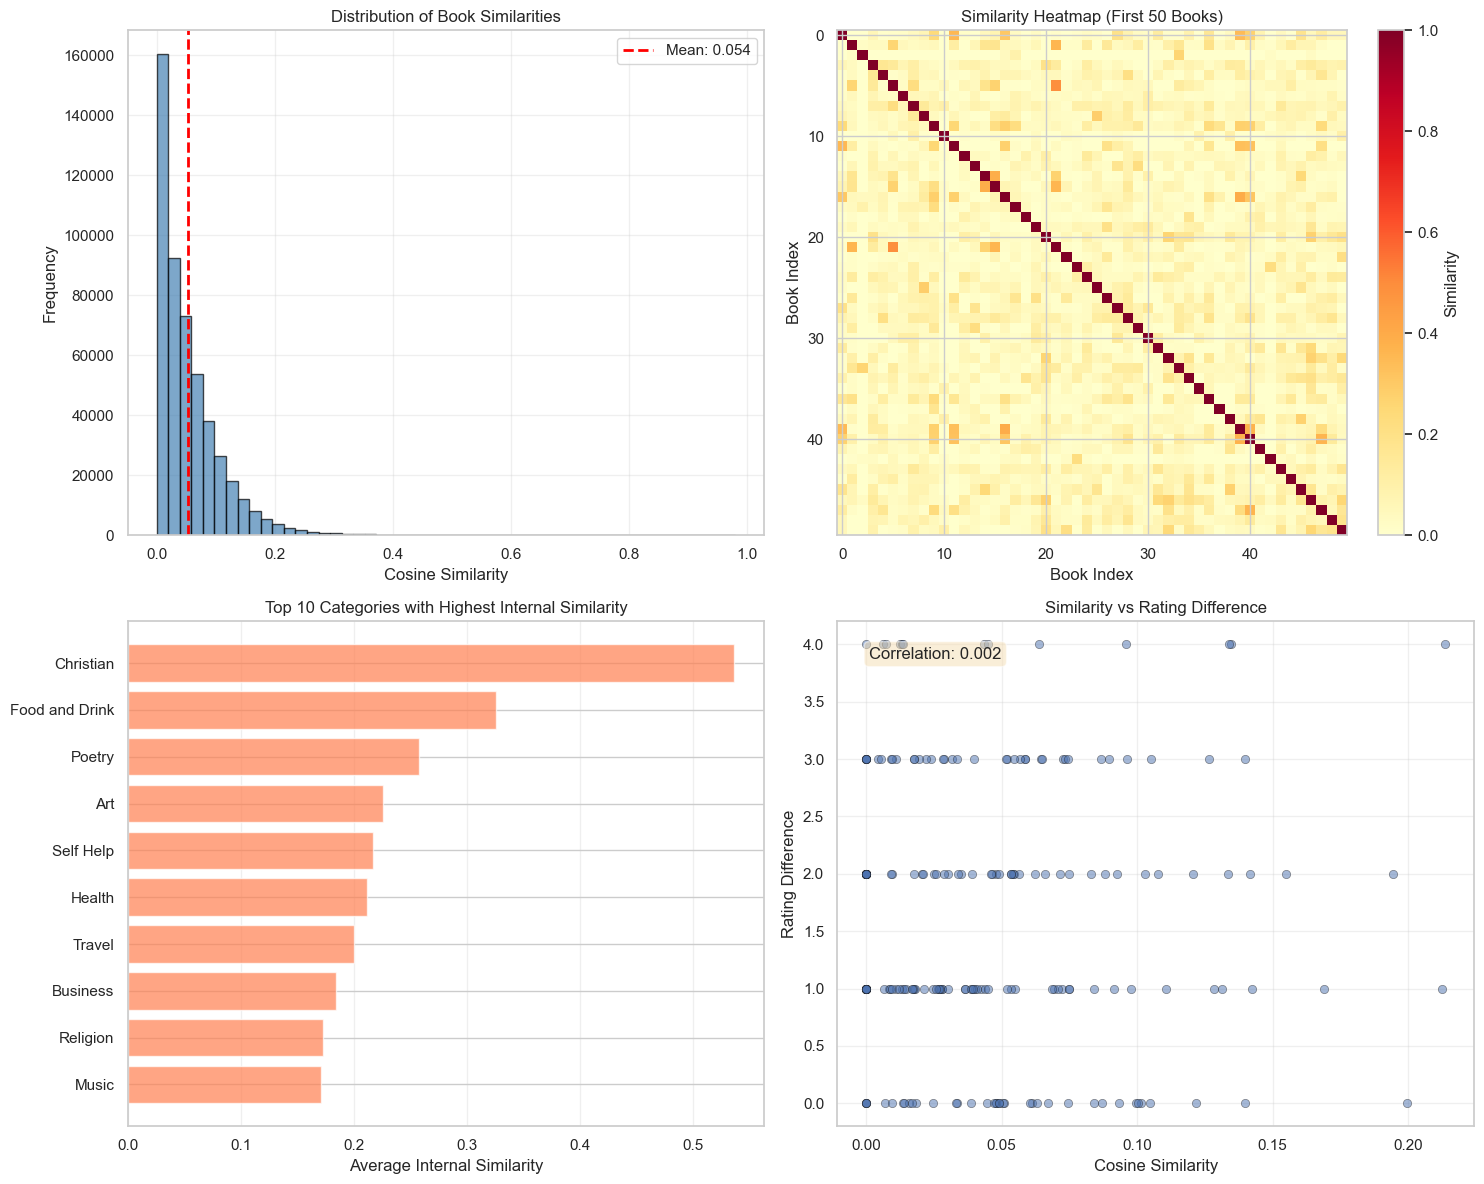

In [23]:
# Visualize Similarity Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Similarity Distribution Histogram
axes[0, 0].hist(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)], 
                bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Book Similarities')
axes[0, 0].axvline(x=similarity_matrix.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {similarity_matrix.mean():.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Heatmap of similarity for a subset (first 50 books)
subset_size = 50
im = axes[0, 1].imshow(similarity_matrix[:subset_size, :subset_size], 
                       cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[0, 1].set_xlabel('Book Index')
axes[0, 1].set_ylabel('Book Index')
axes[0, 1].set_title(f'Similarity Heatmap (First {subset_size} Books)')
plt.colorbar(im, ax=axes[0, 1], label='Similarity')

# 3. Average similarity by category
category_sim = {}
for cat in books['category'].unique():
    cat_indices = books[books['category'] == cat].index.tolist()
    if len(cat_indices) > 1:
        cat_similarities = []
        for i in cat_indices:
            for j in cat_indices:
                if i < j:
                    cat_similarities.append(similarity_matrix[i, j])
        if cat_similarities:
            category_sim[cat] = np.mean(cat_similarities)

# Plot top 10 categories by internal similarity
top_similar_cats = sorted(category_sim.items(), key=lambda x: x[1], reverse=True)[:10]
cats, sims = zip(*top_similar_cats)
axes[1, 0].barh(range(len(cats)), sims, color='coral', alpha=0.7)
axes[1, 0].set_yticks(range(len(cats)))
axes[1, 0].set_yticklabels(cats)
axes[1, 0].set_xlabel('Average Internal Similarity')
axes[1, 0].set_title('Top 10 Categories with Highest Internal Similarity')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Similarity vs Rating scatter
# Sample 200 book pairs
sample_pairs = np.random.choice(len(books), size=(200, 2), replace=True)
pair_similarities = [similarity_matrix[i, j] for i, j in sample_pairs]
rating_diffs = [abs(books.iloc[i]['rating'] - books.iloc[j]['rating']) for i, j in sample_pairs]

axes[1, 1].scatter(pair_similarities, rating_diffs, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[1, 1].set_xlabel('Cosine Similarity')
axes[1, 1].set_ylabel('Rating Difference')
axes[1, 1].set_title('Similarity vs Rating Difference')
axes[1, 1].grid(True, alpha=0.3)

# Add correlation
corr = np.corrcoef(pair_similarities, rating_diffs)[0, 1]
axes[1, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[1, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

save_fig(fig, 'book_similarity_analysis.png')
print('Similarity analysis visualization complete!')

In [26]:
# Build Book Recommendation System
class BookRecommender:
    """Content-based book recommendation system using similarity vectors."""
    
    def __init__(self, books_df, similarity_matrix):
        self.books = books_df.reset_index(drop=True)
        self.similarity_matrix = similarity_matrix
        
    def recommend_by_title(self, book_title, n_recommendations=5):
        """Get recommendations based on a book title."""
        # Find matching books (escape regex special characters)
        import re
        escaped_title = re.escape(book_title)
        matches = self.books[self.books['title'].str.contains(escaped_title, case=False, na=False, regex=True)]
        
        if len(matches) == 0:
            return {"error": f"No books found matching '{book_title}'"}
        
        # Use first match
        idx = matches.index[0]
        book_info = self.books.iloc[idx]
        
        # Get similarity scores
        sim_scores = list(enumerate(self.similarity_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n_recommendations+1]
        
        # Get recommendations
        book_indices = [i[0] for i in sim_scores]
        scores = [i[1] for i in sim_scores]
        
        recommendations = self.books.iloc[book_indices][['title', 'category', 'rating', 'price']].copy()
        recommendations['similarity'] = scores
        recommendations['match_reason'] = 'Similar content and category'
        
        return {
            'input_book': book_info[['title', 'category', 'rating', 'price']].to_dict(),
            'recommendations': recommendations
        }
    
    def recommend_by_category(self, category, n_recommendations=5, min_rating=3.0):
        """Get top-rated books from a specific category."""
        category_books = self.books[
            (self.books['category'].str.contains(category, case=False, na=False)) &
            (self.books['rating'] >= min_rating)
        ].sort_values('rating', ascending=False).head(n_recommendations)
        
        return category_books[['title', 'category', 'rating', 'price']]
    
    def recommend_hybrid(self, book_title, n_recommendations=5, diversity_factor=0.3):
        """Hybrid recommendation: mix similar books with diverse high-rated options."""
        result = self.recommend_by_title(book_title, n_recommendations=n_recommendations*2)
        
        if 'error' in result:
            return result
        
        similar_books = result['recommendations']
        
        # Add diversity: include some high-rated books from different categories
        input_category = result['input_book']['category']
        diverse_books = self.books[
            (self.books['category'] != input_category) &
            (self.books['rating'] >= 4.0)
        ].sample(n=min(int(n_recommendations * diversity_factor), len(self.books)))
        
        # Combine and return top N
        all_recommendations = pd.concat([
            similar_books.head(int(n_recommendations * (1-diversity_factor))),
            diverse_books[['title', 'category', 'rating', 'price']].assign(
                similarity=0.5, 
                match_reason='High-rated diverse selection'
            )
        ]).head(n_recommendations)
        
        return {
            'input_book': result['input_book'],
            'recommendations': all_recommendations
        }

# Initialize recommender
recommender = BookRecommender(books, similarity_matrix)
print('✅ Book Recommender System initialized!')
print(f'   Ready to recommend from {len(books)} books')

✅ Book Recommender System initialized!
   Ready to recommend from 1000 books


In [27]:
# Test Recommendation System
print('='*70)
print('TESTING BOOK RECOMMENDATION SYSTEM')
print('='*70)

# Test 1: Content-based recommendations
test_title = books.iloc[10]['title']
print(f'\n📚 Test 1: Content-Based Recommendations')
print(f'Input: "{test_title}"')
result1 = recommender.recommend_by_title(test_title, n_recommendations=5)
print(f'\nInput Book Details:')
for key, val in result1['input_book'].items():
    print(f'   {key}: {val}')
print('\nTop 5 Recommendations:')
print(result1['recommendations'].to_string(index=False))

# Test 2: Category-based recommendations
print(f'\n\n📚 Test 2: Category-Based Recommendations')
test_category = 'Fiction'
print(f'Category: {test_category} (min rating: 4.0)')
result2 = recommender.recommend_by_category(test_category, n_recommendations=5, min_rating=4.0)
print('\nTop-Rated Books:')
print(result2.to_string(index=False))

# Test 3: Hybrid recommendations
print(f'\n\n📚 Test 3: Hybrid Recommendations (Similar + Diverse)')
test_title2 = books.iloc[25]['title']
print(f'Input: "{test_title2}"')
result3 = recommender.recommend_hybrid(test_title2, n_recommendations=5, diversity_factor=0.3)
print(f'\nInput Book Details:')
for key, val in result3['input_book'].items():
    print(f'   {key}: {val}')
print('\nHybrid Recommendations (70% similar, 30% diverse):')
print(result3['recommendations'].to_string(index=False))

# Test 4: Multiple examples
print(f'\n\n📚 Test 4: Quick Recommendations for Various Books')
sample_titles = books.sample(3)['title'].tolist()
for title in sample_titles:
    result = recommender.recommend_by_title(title, n_recommendations=3)
    print(f'\n"{title}" → Top 3 similar books:')
    for _, row in result['recommendations'].iterrows():
        print(f'   • {row["title"]} (sim: {row["similarity"]:.3f})')

print('\n' + '='*70)

TESTING BOOK RECOMMENDATION SYSTEM

📚 Test 1: Content-Based Recommendations
Input: "Starving Hearts (Triangular Trade Trilogy, #1)"

Input Book Details:
   title: Starving Hearts (Triangular Trade Trilogy, #1)
   category: Default
   rating: 2
   price: 13.99

Top 5 Recommendations:
                                                                        title       category  rating  price  similarity                 match_reason
                                                            Eat Fat, Get Thin         Health       2  54.07    0.397129 Similar content and category
                                                              The Silent Wife        Fiction       5  12.34    0.304072 Similar content and category
                                     8 Keys to Mental Health Through Exercise     Psychology       1  31.04    0.288173 Similar content and category
The Wicked + The Divine, Vol. 3: Commercial Suicide (The Wicked + The Divine) Sequential Art       3  14.41    0.282616 

In [28]:
# Save Similarity Artifacts
import scipy.sparse as sp

# Save similarity matrix (sparse format for efficiency)
similarity_sparse = sp.csr_matrix(similarity_matrix)
sp.save_npz(PROC_DIR / 'similarity_matrix.npz', similarity_sparse)

# Save TF-IDF vectorizer
joblib.dump(tfidf, PROC_DIR / 'tfidf_vectorizer.joblib')

# Save book index mapping
book_index = books[['title', 'category']].reset_index()
book_index.to_csv(PROC_DIR / 'book_index.csv', index=False)

# Create recommendation metadata
recommendation_metadata = {
    'n_books': len(books),
    'n_features': tfidf_matrix.shape[1],
    'vectorizer_params': {
        'max_features': 500,
        'ngram_range': (1, 2),
        'min_df': 2,
        'max_df': 0.8
    },
    'similarity_stats': {
        'mean': float(similarity_matrix.mean()),
        'std': float(similarity_matrix.std()),
        'min': float(similarity_matrix.min()),
        'max': float(similarity_matrix.max())
    },
    'top_categories_by_similarity': dict(sorted(category_sim.items(), key=lambda x: x[1], reverse=True)[:10])
}

with open(PROC_DIR / 'recommendation_metadata.json', 'w') as f:
    json.dump(recommendation_metadata, f, indent=2)

print('='*70)
print('SIMILARITY ARTIFACTS SAVED')
print('='*70)
print(f'\n💾 Saved Files:')
print(f'   1. Similarity Matrix:     {PROC_DIR / "similarity_matrix.npz"}')
print(f'   2. TF-IDF Vectorizer:     {PROC_DIR / "tfidf_vectorizer.joblib"}')
print(f'   3. Book Index:            {PROC_DIR / "book_index.csv"}')
print(f'   4. Recommendation Config: {PROC_DIR / "recommendation_metadata.json"}')

print(f'\n📊 Similarity Statistics:')
print(f'   • Books analyzed: {recommendation_metadata["n_books"]}')
print(f'   • Features extracted: {recommendation_metadata["n_features"]}')
print(f'   • Mean similarity: {recommendation_metadata["similarity_stats"]["mean"]:.4f}')
print(f'   • Std similarity: {recommendation_metadata["similarity_stats"]["std"]:.4f}')

print(f'\n🏆 Most Cohesive Categories:')
for cat, sim in list(recommendation_metadata['top_categories_by_similarity'].items())[:5]:
    print(f'   • {cat}: {sim:.4f}')

print('\n' + '='*70)

SIMILARITY ARTIFACTS SAVED

💾 Saved Files:
   1. Similarity Matrix:     data\processed\similarity_matrix.npz
   2. TF-IDF Vectorizer:     data\processed\tfidf_vectorizer.joblib
   3. Book Index:            data\processed\book_index.csv
   4. Recommendation Config: data\processed\recommendation_metadata.json

📊 Similarity Statistics:
   • Books analyzed: 1000
   • Features extracted: 500
   • Mean similarity: 0.0540
   • Std similarity: 0.0632

🏆 Most Cohesive Categories:
   • Christian: 0.5359
   • Food and Drink: 0.3256
   • Poetry: 0.2576
   • Art: 0.2254
   • Self Help: 0.2166



## Collaborative Filtering - Anime Rating Prediction

This section implements user-based collaborative filtering to predict how users will rate anime titles they haven't watched yet. We'll demonstrate multiple approaches:

1. **User-Based Collaborative Filtering**: Find similar users and predict based on their ratings
2. **Item-Based Collaborative Filtering**: Find similar anime and predict based on user's ratings of similar items
3. **Matrix Factorization (SVD)**: Decompose the user-item matrix to discover latent features
4. **Evaluation**: Measure prediction accuracy using RMSE and MAE

In [ ]:
# Generate Synthetic Anime Rating Data
print('Generating synthetic anime rating dataset...')
np.random.seed(42)

# Create anime catalog
n_anime = 200
n_users = 500

anime_genres = ['Action', 'Comedy', 'Drama', 'Romance', 'Sci-Fi', 'Fantasy', 
                'Horror', 'Slice of Life', 'Sports', 'Mystery', 'Thriller']
anime_types = ['TV', 'Movie', 'OVA', 'Special']

anime_data = pd.DataFrame({
    'anime_id': range(1, n_anime + 1),
    'title': [f'Anime_{i}' for i in range(1, n_anime + 1)],
    'genre': np.random.choice(anime_genres, n_anime),
    'type': np.random.choice(anime_types, n_anime),
    'episodes': np.random.choice([12, 24, 26, 52, 1, 2, 6], n_anime),
    'avg_rating': np.random.uniform(5.5, 9.5, n_anime).round(2)
})

# Generate user-anime ratings (sparse matrix)
# Not all users rate all anime - create realistic sparsity (~5% density)
n_ratings = int(n_users * n_anime * 0.05)

user_ids = np.random.choice(range(1, n_users + 1), n_ratings)
anime_ids = np.random.choice(range(1, n_anime + 1), n_ratings)

# Generate ratings with some patterns:
# - Users tend to rate anime from their preferred genres higher
# - Ratings correlate with anime's average rating but with personal variance
ratings = []
for anime_id in anime_ids:
    avg_rating = anime_data.loc[anime_data['anime_id'] == anime_id, 'avg_rating'].values[0]
    # Add personal variance: N(avg_rating, std=1.5) clipped to [1, 10]
    rating = np.clip(np.random.normal(avg_rating, 1.5), 1, 10)
    ratings.append(round(rating))

# Create ratings dataframe
ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'anime_id': anime_ids,
    'rating': ratings
})

# Remove duplicates (keep first rating)
ratings_df = ratings_df.drop_duplicates(subset=['user_id', 'anime_id'], keep='first')

print(f'\n✅ Synthetic Dataset Created:')
print(f'   • Anime titles: {n_anime}')
print(f'   • Users: {n_users}')
print(f'   • Ratings: {len(ratings_df):,}')
print(f'   • Sparsity: {(1 - len(ratings_df) / (n_users * n_anime)) * 100:.2f}%')
print(f'   • Avg ratings per user: {len(ratings_df) / n_users:.1f}')
print(f'   • Avg ratings per anime: {len(ratings_df) / n_anime:.1f}')

print('\n📊 Rating Distribution:')
print(ratings_df['rating'].value_counts().sort_index())

In [ ]:
# Create User-Item Rating Matrix
from scipy.sparse import csr_matrix

# Pivot to create user-item matrix
user_item_matrix = ratings_df.pivot(index='user_id', columns='anime_id', values='rating')

print('Creating user-item rating matrix...')
print(f'\n📋 Matrix Shape: {user_item_matrix.shape} (users × anime)')
print(f'   Non-null ratings: {user_item_matrix.notna().sum().sum():,}')
print(f'   Matrix density: {(user_item_matrix.notna().sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%')

# Fill NaN with 0 for computation (0 = not rated)
user_item_matrix_filled = user_item_matrix.fillna(0)

# Split into train/test for evaluation
from sklearn.model_selection import train_test_split

# Split ratings into train/test (80/20)
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f'\n🔄 Train/Test Split:')
print(f'   Training ratings: {len(train_data):,}')
print(f'   Test ratings: {len(test_data):,}')

# Create train matrix
train_matrix = train_data.pivot(index='user_id', columns='anime_id', values='rating')
train_matrix_filled = train_matrix.fillna(0)

print('\n✅ Matrices ready for collaborative filtering!')

In [ ]:
# User-Based Collaborative Filtering
from sklearn.metrics.pairwise import cosine_similarity

class UserBasedCF:
    """User-based collaborative filtering for anime rating prediction."""
    
    def __init__(self, user_item_matrix, k_neighbors=20):
        """
        Initialize the recommender.
        
        Args:
            user_item_matrix: DataFrame with users as rows, items as columns
            k_neighbors: Number of similar users to consider
        """
        self.user_item_matrix = user_item_matrix.fillna(0)
        self.k_neighbors = k_neighbors
        
        # Calculate user-user similarity matrix
        print(f'Calculating user-user similarity (cosine)...')
        self.user_similarity = cosine_similarity(self.user_item_matrix)
        self.user_similarity_df = pd.DataFrame(
            self.user_similarity,
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )
        print(f'✅ User similarity matrix: {self.user_similarity.shape}')
    
    def predict_rating(self, user_id, anime_id):
        """
        Predict rating for a specific user-anime pair.
        
        Args:
            user_id: User ID
            anime_id: Anime ID
            
        Returns:
            Predicted rating (1-10)
        """
        # Check if user exists
        if user_id not in self.user_item_matrix.index:
            return self.user_item_matrix[anime_id].mean() if anime_id in self.user_item_matrix.columns else 5.0
        
        # Check if anime exists
        if anime_id not in self.user_item_matrix.columns:
            return self.user_item_matrix.loc[user_id].mean() if self.user_item_matrix.loc[user_id].sum() > 0 else 5.0
        
        # Find k most similar users who rated this anime
        user_sims = self.user_similarity_df[user_id].drop(user_id)
        anime_ratings = self.user_item_matrix[anime_id]
        
        # Filter users who rated this anime
        rated_mask = anime_ratings > 0
        similar_users = user_sims[rated_mask].nlargest(self.k_neighbors)
        
        if len(similar_users) == 0:
            # No similar users rated this anime, return global average
            return anime_ratings[anime_ratings > 0].mean() if (anime_ratings > 0).any() else 5.0
        
        # Weighted average of ratings from similar users
        similar_ratings = anime_ratings[similar_users.index]
        
        # Handle potential negative similarities
        similarities = similar_users.values
        similarities = np.maximum(similarities, 0)  # Set negative similarities to 0
        
        if similarities.sum() == 0:
            return similar_ratings.mean()
        
        predicted_rating = np.average(similar_ratings, weights=similarities)
        
        # Clip to valid range
        return np.clip(predicted_rating, 1, 10)
    
    def predict_batch(self, test_pairs):
        """
        Predict ratings for multiple user-anime pairs.
        
        Args:
            test_pairs: DataFrame with 'user_id' and 'anime_id' columns
            
        Returns:
            Array of predicted ratings
        """
        predictions = []
        for _, row in test_pairs.iterrows():
            pred = self.predict_rating(row['user_id'], row['anime_id'])
            predictions.append(pred)
        return np.array(predictions)

# Initialize user-based CF
print('='*70)
print('USER-BASED COLLABORATIVE FILTERING')
print('='*70)

user_cf = UserBasedCF(train_matrix, k_neighbors=20)

# Make predictions on test set
print('\nMaking predictions on test set...')
test_predictions = user_cf.predict_batch(test_data[['user_id', 'anime_id']])

# Calculate error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_actuals = test_data['rating'].values
rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
mae = mean_absolute_error(test_actuals, test_predictions)

print(f'\n📊 User-Based CF Performance:')
print(f'   RMSE: {rmse:.4f}')
print(f'   MAE: {mae:.4f}')
print(f'   Avg actual rating: {test_actuals.mean():.2f}')
print(f'   Avg predicted rating: {test_predictions.mean():.2f}')

In [ ]:
# Item-Based Collaborative Filtering
class ItemBasedCF:
    """Item-based collaborative filtering for anime rating prediction."""
    
    def __init__(self, user_item_matrix, k_neighbors=20):
        """
        Initialize the recommender.
        
        Args:
            user_item_matrix: DataFrame with users as rows, items as columns
            k_neighbors: Number of similar items to consider
        """
        self.user_item_matrix = user_item_matrix.fillna(0)
        self.k_neighbors = k_neighbors
        
        # Calculate item-item similarity matrix (transpose to get items × users)
        print(f'Calculating item-item similarity (cosine)...')
        item_matrix = self.user_item_matrix.T
        self.item_similarity = cosine_similarity(item_matrix)
        self.item_similarity_df = pd.DataFrame(
            self.item_similarity,
            index=item_matrix.index,
            columns=item_matrix.index
        )
        print(f'✅ Item similarity matrix: {self.item_similarity.shape}')
    
    def predict_rating(self, user_id, anime_id):
        """Predict rating for a specific user-anime pair."""
        # Check if user exists
        if user_id not in self.user_item_matrix.index:
            return 5.0
        
        # Check if anime exists
        if anime_id not in self.user_item_matrix.columns:
            return self.user_item_matrix.loc[user_id].mean() if self.user_item_matrix.loc[user_id].sum() > 0 else 5.0
        
        # Get user's ratings
        user_ratings = self.user_item_matrix.loc[user_id]
        
        # Find k most similar anime that user has rated
        anime_sims = self.item_similarity_df[anime_id].drop(anime_id)
        rated_mask = user_ratings > 0
        similar_anime = anime_sims[rated_mask].nlargest(self.k_neighbors)
        
        if len(similar_anime) == 0:
            # User hasn't rated any similar anime
            return user_ratings[user_ratings > 0].mean() if (user_ratings > 0).any() else 5.0
        
        # Weighted average based on similarity
        user_ratings_similar = user_ratings[similar_anime.index]
        similarities = similar_anime.values
        similarities = np.maximum(similarities, 0)  # Set negative similarities to 0
        
        if similarities.sum() == 0:
            return user_ratings_similar.mean()
        
        predicted_rating = np.average(user_ratings_similar, weights=similarities)
        
        return np.clip(predicted_rating, 1, 10)
    
    def predict_batch(self, test_pairs):
        """Predict ratings for multiple user-anime pairs."""
        predictions = []
        for _, row in test_pairs.iterrows():
            pred = self.predict_rating(row['user_id'], row['anime_id'])
            predictions.append(pred)
        return np.array(predictions)

# Initialize item-based CF
print('='*70)
print('ITEM-BASED COLLABORATIVE FILTERING')
print('='*70)

item_cf = ItemBasedCF(train_matrix, k_neighbors=20)

# Make predictions
print('\nMaking predictions on test set...')
test_predictions_item = item_cf.predict_batch(test_data[['user_id', 'anime_id']])

# Calculate metrics
rmse_item = np.sqrt(mean_squared_error(test_actuals, test_predictions_item))
mae_item = mean_absolute_error(test_actuals, test_predictions_item)

print(f'\n📊 Item-Based CF Performance:')
print(f'   RMSE: {rmse_item:.4f}')
print(f'   MAE: {mae_item:.4f}')
print(f'   Avg predicted rating: {test_predictions_item.mean():.2f}')

In [ ]:
# Matrix Factorization (SVD) for Rating Prediction
from scipy.sparse.linalg import svds

class MatrixFactorizationCF:
    """Matrix Factorization using SVD for rating prediction."""
    
    def __init__(self, user_item_matrix, n_factors=50):
        """
        Initialize matrix factorization model.
        
        Args:
            user_item_matrix: DataFrame with users as rows, items as columns
            n_factors: Number of latent factors
        """
        self.user_item_matrix = user_item_matrix.fillna(0)
        self.n_factors = min(n_factors, min(user_item_matrix.shape) - 1)
        self.user_ids = user_item_matrix.index
        self.anime_ids = user_item_matrix.columns
        
        print(f'Performing SVD with {self.n_factors} latent factors...')
        
        # Center the ratings (subtract mean)
        self.user_ratings_mean = np.array(self.user_item_matrix.mean(axis=1))
        matrix_centered = self.user_item_matrix.values - self.user_ratings_mean.reshape(-1, 1)
        
        # Perform SVD
        U, sigma, Vt = svds(matrix_centered, k=self.n_factors)
        
        # Store factors
        self.U = U
        self.sigma = np.diag(sigma)
        self.Vt = Vt
        
        # Compute predicted ratings matrix
        self.predictions_matrix = np.dot(np.dot(U, self.sigma), Vt) + self.user_ratings_mean.reshape(-1, 1)
        self.predictions_df = pd.DataFrame(
            self.predictions_matrix,
            index=self.user_ids,
            columns=self.anime_ids
        )
        
        print(f'✅ SVD complete!')
        print(f'   User factors: {U.shape}')
        print(f'   Item factors: {Vt.shape}')
    
    def predict_rating(self, user_id, anime_id):
        """Predict rating for a specific user-anime pair."""
        if user_id not in self.predictions_df.index or anime_id not in self.predictions_df.columns:
            return 5.0
        
        predicted = self.predictions_df.loc[user_id, anime_id]
        return np.clip(predicted, 1, 10)
    
    def predict_batch(self, test_pairs):
        """Predict ratings for multiple user-anime pairs."""
        predictions = []
        for _, row in test_pairs.iterrows():
            pred = self.predict_rating(row['user_id'], row['anime_id'])
            predictions.append(pred)
        return np.array(predictions)

# Initialize matrix factorization
print('='*70)
print('MATRIX FACTORIZATION (SVD)')
print('='*70)

mf_cf = MatrixFactorizationCF(train_matrix, n_factors=50)

# Make predictions
print('\nMaking predictions on test set...')
test_predictions_mf = mf_cf.predict_batch(test_data[['user_id', 'anime_id']])

# Calculate metrics
rmse_mf = np.sqrt(mean_squared_error(test_actuals, test_predictions_mf))
mae_mf = mean_absolute_error(test_actuals, test_predictions_mf)

print(f'\n📊 Matrix Factorization Performance:')
print(f'   RMSE: {rmse_mf:.4f}')
print(f'   MAE: {mae_mf:.4f}')
print(f'   Avg predicted rating: {test_predictions_mf.mean():.2f}')

In [ ]:
# Compare All Methods
print('='*70)
print('MODEL COMPARISON')
print('='*70)

comparison_results = pd.DataFrame({
    'Model': ['User-Based CF', 'Item-Based CF', 'Matrix Factorization'],
    'RMSE': [rmse, rmse_item, rmse_mf],
    'MAE': [mae, mae_item, mae_mf]
})

print('\n📊 Performance Comparison:')
print(comparison_results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
axes[0].bar(comparison_results['Model'], comparison_results['RMSE'], 
            color=['steelblue', 'coral', 'lightgreen'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('RMSE (lower is better)')
axes[0].set_title('Root Mean Squared Error Comparison')
axes[0].set_xticklabels(comparison_results['Model'], rotation=15, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (model, rmse_val) in enumerate(zip(comparison_results['Model'], comparison_results['RMSE'])):
    axes[0].text(i, rmse_val + 0.02, f'{rmse_val:.3f}', ha='center', va='bottom', fontweight='bold')

# MAE comparison
axes[1].bar(comparison_results['Model'], comparison_results['MAE'], 
            color=['steelblue', 'coral', 'lightgreen'], alpha=0.8, edgecolor='black')
axes[1].set_ylabel('MAE (lower is better)')
axes[1].set_title('Mean Absolute Error Comparison')
axes[1].set_xticklabels(comparison_results['Model'], rotation=15, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (model, mae_val) in enumerate(zip(comparison_results['Model'], comparison_results['MAE'])):
    axes[1].text(i, mae_val + 0.02, f'{mae_val:.3f}', ha='center', va='bottom', fontweight='bold')

save_fig(fig, 'cf_model_comparison.png')

# Determine best model
best_model_idx = comparison_results['RMSE'].idxmin()
best_model = comparison_results.loc[best_model_idx, 'Model']
best_rmse = comparison_results.loc[best_model_idx, 'RMSE']
best_mae = comparison_results.loc[best_model_idx, 'MAE']

print(f'\n🏆 Best Model: {best_model}')
print(f'   RMSE: {best_rmse:.4f}')
print(f'   MAE: {best_mae:.4f}')
print(f'\n💡 Interpretation:')
print(f'   On average, predictions are off by ±{best_mae:.2f} rating points')
print(f'   For a 1-10 rating scale, this is {(best_mae/9)*100:.1f}% error')

In [ ]:
# Prediction Error Analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

models = ['User-Based CF', 'Item-Based CF', 'Matrix Factorization']
predictions_list = [test_predictions, test_predictions_item, test_predictions_mf]

for idx, (model_name, preds) in enumerate(zip(models, predictions_list)):
    # Calculate errors
    errors = test_actuals - preds
    
    # Error distribution
    axes[idx].hist(errors, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[idx].axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2, 
                      label=f'Mean: {errors.mean():.2f}')
    axes[idx].set_xlabel('Prediction Error (Actual - Predicted)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{model_name} - Error Distribution')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Actual vs Predicted scatter
    axes[idx + 3].scatter(test_actuals, preds, alpha=0.5, s=10, edgecolors='k', linewidth=0.3)
    axes[idx + 3].plot([1, 10], [1, 10], 'r--', lw=2, label='Perfect Prediction')
    axes[idx + 3].set_xlabel('Actual Rating')
    axes[idx + 3].set_ylabel('Predicted Rating')
    axes[idx + 3].set_title(f'{model_name} - Actual vs Predicted')
    axes[idx + 3].legend()
    axes[idx + 3].grid(True, alpha=0.3)
    axes[idx + 3].set_xlim(0.5, 10.5)
    axes[idx + 3].set_ylim(0.5, 10.5)
    
    # Add R² score
    from sklearn.metrics import r2_score
    r2 = r2_score(test_actuals, preds)
    axes[idx + 3].text(0.05, 0.95, f'R² = {r2:.3f}', 
                       transform=axes[idx + 3].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

save_fig(fig, 'cf_error_analysis.png')
print('Error analysis visualization complete!')

In [ ]:
# Demo: Make Predictions for a Specific User
def demo_user_predictions(user_id, model, model_name, n_recommendations=10):
    """
    Generate anime recommendations for a specific user.
    
    Args:
        user_id: User ID to generate recommendations for
        model: Trained collaborative filtering model
        model_name: Name of the model
        n_recommendations: Number of recommendations to generate
    """
    print(f'\n{"="*70}')
    print(f'PERSONALIZED ANIME PREDICTIONS FOR USER {user_id}')
    print(f'Model: {model_name}')
    print(f'{"="*70}')
    
    # Get user's rated anime
    user_ratings = ratings_df[ratings_df['user_id'] == user_id].copy()
    
    if len(user_ratings) == 0:
        print(f'⚠️  User {user_id} has no ratings in the dataset')
        return
    
    print(f'\n📺 User {user_id} has rated {len(user_ratings)} anime:')
    user_ratings_display = user_ratings.merge(anime_data[['anime_id', 'title', 'genre']], on='anime_id')
    print(user_ratings_display[['title', 'genre', 'rating']].sort_values('rating', ascending=False).head(10).to_string(index=False))
    
    # Find anime user hasn't rated
    rated_anime = set(user_ratings['anime_id'])
    unrated_anime = [aid for aid in anime_data['anime_id'] if aid not in rated_anime]
    
    # Predict ratings for unrated anime
    predictions = []
    for anime_id in unrated_anime:
        pred_rating = model.predict_rating(user_id, anime_id)
        predictions.append({
            'anime_id': anime_id,
            'predicted_rating': pred_rating
        })
    
    predictions_df = pd.DataFrame(predictions)
    predictions_df = predictions_df.merge(anime_data[['anime_id', 'title', 'genre', 'type', 'episodes']], on='anime_id')
    
    # Top recommendations
    top_recommendations = predictions_df.nlargest(n_recommendations, 'predicted_rating')
    
    print(f'\n🌟 Top {n_recommendations} Recommended Anime (Predicted to Rate Highest):')
    print(top_recommendations[['title', 'genre', 'type', 'predicted_rating']].to_string(index=False))
    
    # Genre analysis
    print(f'\n📊 User\'s Genre Preferences (from rated anime):')
    genre_avg = user_ratings_display.groupby('genre')['rating'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    print(genre_avg.head(5))
    
    print(f'\n💡 Recommendation Insights:')
    top_genres = top_recommendations['genre'].value_counts().head(3)
    print(f'   Recommended genres: {", ".join([f"{g} ({c})" for g, c in top_genres.items()])}')
    print(f'   Avg predicted rating: {top_recommendations["predicted_rating"].mean():.2f}')

# Test with a random user
sample_user_id = ratings_df['user_id'].value_counts().head(10).index[0]  # Pick an active user

# Demo with best model
if best_model == 'User-Based CF':
    demo_user_predictions(sample_user_id, user_cf, best_model, n_recommendations=10)
elif best_model == 'Item-Based CF':
    demo_user_predictions(sample_user_id, item_cf, best_model, n_recommendations=10)
else:
    demo_user_predictions(sample_user_id, mf_cf, best_model, n_recommendations=10)

In [ ]:
# Save Collaborative Filtering Models and Artifacts
print('='*70)
print('SAVING COLLABORATIVE FILTERING ARTIFACTS')
print('='*70)

# Save ratings data
ratings_df.to_csv(PROC_DIR / 'anime_ratings.csv', index=False)
anime_data.to_csv(PROC_DIR / 'anime_catalog.csv', index=False)

# Save train/test split
train_data.to_csv(PROC_DIR / 'anime_ratings_train.csv', index=False)
test_data.to_csv(PROC_DIR / 'anime_ratings_test.csv', index=False)

# Save user-item matrix
user_item_matrix.to_csv(PROC_DIR / 'user_item_matrix.csv')

# Save model artifacts
import pickle

# Save user-based CF model
with open(PROC_DIR / 'user_based_cf_model.pkl', 'wb') as f:
    pickle.dump(user_cf, f)

# Save item-based CF model
with open(PROC_DIR / 'item_based_cf_model.pkl', 'wb') as f:
    pickle.dump(item_cf, f)

# Save matrix factorization model
with open(PROC_DIR / 'matrix_factorization_model.pkl', 'wb') as f:
    pickle.dump(mf_cf, f)

# Save evaluation results
cf_metadata = {
    'dataset_stats': {
        'n_users': n_users,
        'n_anime': n_anime,
        'n_ratings': len(ratings_df),
        'sparsity': float((1 - len(ratings_df) / (n_users * n_anime)) * 100),
        'train_size': len(train_data),
        'test_size': len(test_data)
    },
    'model_performance': {
        'user_based_cf': {
            'rmse': float(rmse),
            'mae': float(mae)
        },
        'item_based_cf': {
            'rmse': float(rmse_item),
            'mae': float(mae_item)
        },
        'matrix_factorization': {
            'rmse': float(rmse_mf),
            'mae': float(mae_mf),
            'n_factors': int(mf_cf.n_factors)
        }
    },
    'best_model': best_model,
    'training_date': '2026-01-13'
}

with open(PROC_DIR / 'cf_metadata.json', 'w') as f:
    json.dump(cf_metadata, f, indent=2)

print(f'\n💾 Saved Files:')
print(f'   1. Ratings data:          {PROC_DIR / "anime_ratings.csv"}')
print(f'   2. Anime catalog:         {PROC_DIR / "anime_catalog.csv"}')
print(f'   3. Train/Test splits:     {PROC_DIR / "anime_ratings_train.csv"}')
print(f'   4. User-Item matrix:      {PROC_DIR / "user_item_matrix.csv"}')
print(f'   5. User-Based CF model:   {PROC_DIR / "user_based_cf_model.pkl"}')
print(f'   6. Item-Based CF model:   {PROC_DIR / "item_based_cf_model.pkl"}')
print(f'   7. Matrix Fact. model:    {PROC_DIR / "matrix_factorization_model.pkl"}')
print(f'   8. CF Metadata:           {PROC_DIR / "cf_metadata.json"}')

print(f'\n📊 Summary:')
print(f'   • Dataset: {n_users} users × {n_anime} anime')
print(f'   • Ratings: {len(ratings_df):,} ({(1-cf_metadata["dataset_stats"]["sparsity"]/100)*100:.2f}% dense)')
print(f'   • Best Model: {best_model}')
print(f'   • Best RMSE: {comparison_results["RMSE"].min():.4f}')
print(f'   • Best MAE: {comparison_results["MAE"].min():.4f}')

print('\n✅ All collaborative filtering artifacts saved!')

## 9) Unit tests / Reproducibility
- Move testable functions to `utils.py` and add pytest tests.
- Use `random.seed` and `numpy.random.seed` / `sklearn` random_state for reproducible splits.

## 10) Debugging & Logging
- Use `%debug`, `pdb.set_trace()`, and configure the `logging` module for debug-level logs.

## 11) Profiling & Optimization
- Use `%timeit` and `cProfile` to find hotspots and optimize pandas operations.

## 12) Exporting & CI
- Export to HTML:

```bash
jupyter nbconvert --to html data_exploration.ipynb
```

- For CI, use `papermill` or `nbval` in GitHub Actions to validate notebook execution.

## Final notes
This notebook is a reproducible workflow: it installs required packages, runs EDA, generates figures in `figures/`, saves processed data into `data/processed/`, and includes a simple model example.